# GPM data combining and conversion

#### Combining the gpm highres nc4 datasets for each year and exporting to a singular classic netcdf dataset (individual for each year) to be used as input for nctoolkits cdo for regridding to lowres dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
import xesmf as xe
import cartopy.crs as ccrs
%matplotlib inline
%config IPCompleter.greedy = True

In [2]:
# from dask.diagnostics import ProgressBar

In [3]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
plt.style.use('seaborn-pastel')
sns.set_theme(style="ticks")
# plt.style.use('nature')

In [4]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu_r', cmap_sequential='GnBu')

In [5]:
ds1 = xr.open_dataset('./data/GPM_data/gpm_2002.nc', chunks={'time': 500})

In [6]:
ds1

<xarray.Dataset>
Dimensions:             (time: 17520, bnds: 2, lon: 401, lat: 401)
Coordinates:
  * time                (time) datetime64[ns] 2002-01-01 ... 2002-12-31T23:30:00
  * lon                 (lon) float32 60.05 60.15 60.25 ... 99.85 99.95 100.1
  * lat                 (lat) float32 -0.05 0.05 0.15 0.25 ... 39.75 39.85 39.95
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] dask.array<chunksize=(500, 2), meta=np.ndarray>
    lon_bnds            (lon, bnds) float32 dask.array<chunksize=(401, 2), meta=np.ndarray>
    lat_bnds            (lat, bnds) float32 dask.array<chunksize=(401, 2), meta=np.ndarray>
    precipitationCal    (time, lon, lat) float32 dask.array<chunksize=(500, 401, 401), meta=np.ndarray>
    precipitationUncal  (time, lon, lat) float32 dask.array<chunksize=(500, 401, 401), meta=np.ndarray>
    IRprecipitation     (time, lon, lat) float32 dask.array<chunksize=(500, 401, 401), meta=np.ndarray>
Attributes:
    CDI:                             Climate Data Interface version 1.9.10 (h...
    Conventions:                     CF-1.6
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/06;\nDOIauth...
    FileInfo:                        DataFormatVersion=6a;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         Wed Oct 27 14:12:53 2021: cdo mergetime ...
    CDO:                             Climate Data Operators version 1.9.10 (h...

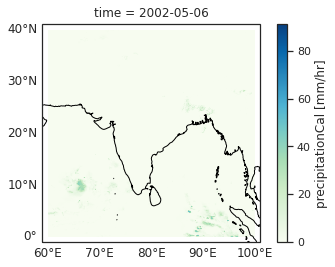

In [7]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([59, 101, -1, 41], crs=ccrs.PlateCarree())
ds1.precipitationCal.transpose('time', 'lat', 'lon').isel(time = 6000).plot(ax = ax)
ax.coastlines()
gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.1, linestyle='--')
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False  # you need False
gridliner.xlines = False  # you need False

In [8]:
ds1.precipitationCal.shape

(17520, 401, 401)

In [15]:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(0, 40.25, 0.25)),
                     'lon': (['lon'], np.arange(60, 100.25, 0.25)),
                    }
                   )
ds_out

<xarray.Dataset>
Dimensions:  (lat: 161, lon: 161)
Coordinates:
  * lat      (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.0 39.25 39.5 39.75 40.0
  * lon      (lon) float64 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
Data variables:
    *empty*

In [16]:
regridder = xe.Regridder(ds1, ds_out, 'bilinear')
# regridder.clean_weight_file()
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_401x401_161x161.nc 
Reuse pre-computed weights? False 
Input grid shape:           (401, 401) 
Output grid shape:          (161, 161) 
Periodic in longitude?      False

In [19]:
%time dr_out = regridder(ds1.precipitationCal)
dr_out

CPU times: user 1.84 s, sys: 29.4 ms, total: 1.86 s
Wall time: 2.43 s


/home/nkv/.miniconda/lib/python3.9/site-packages/dask/array/gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 36
  tmp = blockwise(


<xarray.DataArray (time: 17520, lat: 161, lon: 161)>
dask.array<transpose, shape=(17520, 161, 161), dtype=float32, chunksize=(500, 161, 161), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2002-01-01 ... 2002-12-31T23:30:00
  * lon      (lon) float64 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.0 39.25 39.5 39.75 40.0
Attributes:
    regrid_method:  bilinear

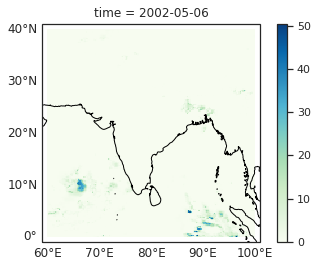

In [20]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([59, 101, -1, 41], crs=ccrs.PlateCarree())
dr_out.transpose('time', 'lat', 'lon').isel(time = 6000).plot(ax = ax)
ax.coastlines()
gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.1, linestyle='--')
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False  # you need False
gridliner.xlines = False  # you need False